In [13]:
from utils import * 
from algorithms import *
from agents import *

# parameters
disclosure = ['step'];
numStates = 6;
depth = 1

# game setup
numRounds, numPeriods, numSteps, numBuyers, numSellers, numTokens, gameTypes, seed = 5000, 1, 16, 4, 4, 4, '1111', None
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]

# algo params
episodeLength = 16
numTrajectories = 10
gamma=0.99
std_init = 0.7
std_decay = 0.995
std_min = 0.05
lr = 0.0003
k = -0.15
p = 0.3

# agents
buyers = [
           Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
         ]
sellers = [Reinforcer(gameData, disclosure, index=0, buyer=0, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)
          ]

# logging
log = Log(gameData, disclosure,depth)
printInterval1, printInterval2, cnt, bprofits_history, sprofits_history, bidder_bids, bidder_profits = 100, 300, 0, [], [], [], []

# training loop
bprofits, sprofits = 0.0, 0.0
for rnd in range(numRounds):
    print(rnd, bprofits, sprofits)
    startRounds(gameData, log, buyers, sellers, rnd)
    bprofits, sprofits = 0.0, 0.0
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        for step in range(numSteps):

            # start step
            startSteps(buyers, sellers)

            # reset state
            for i in range(numBuyers):
                buyers[i].state = log.generateState(buyers[i], cnt, numStates)
                sellers[i].state = log.generateState(sellers[i], cnt, numStates)

            # bid-ask
            bids, asks = collectOffers(buyers, sellers)
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)

            # transact
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits

            # record
            bprofits += buyers[0].stepProfits
            sprofits += sellers[0].stepProfits
            log.addStep([rnd, period, step, currentBid, currentAsk,  buy, sell, price, price>0,
                         currentBidIdx==0, currentBidIdx==1, currentBidIdx==2, currentBidIdx==3, 
                         currentAskIdx==0, currentAskIdx==1, currentAskIdx==2, currentAskIdx==3, 
                         bids[0], bids[1], bids[2], bids[3], 
                         asks[0], asks[1], asks[2], asks[3], 
                         bprofit, sprofit])

            # end step
            observe(buyers, sellers, log.disclose())
            endSteps(buyers, sellers)

            # update state
            for i in range(numBuyers):
                buyers[i].newState = log.generateState(buyers[i], cnt, numStates)
                sellers[i].newState = log.generateState(sellers[i], cnt, numStates)

            # terminate period
            if step == numSteps - 1:
                for i in range(numBuyers):
                    buyers[i].done = True   
                    sellers[i].done = True                  
            else:
                for i in range(numBuyers):
                    buyers[i].done = False
                    sellers[i].done = False                  

            agentsObserve(buyers, sellers)
            agentsTrain(buyers, sellers)
            cnt+=1
        endPeriods(buyers, sellers)
    endRounds(buyers, sellers)

0 0.0 0.0
1 48.64997349022224 32.01819629985326
2 67.04313577421092 60.46609995065664
3 53.620017030024854 14.45892138796134
4 18.55990942936677 55.610889405881174
5 53.53583326345148 20.379040848870353
6 61.49703988925186 30.058884246504164
7 47.61319282429973 48.3574755094069
8 51.126872156779385 48.94761868010182
9 67.13241876289214 19.341906515595667
10 63.49500276173532 46.05849499896978
11 61.98527710519887 35.88587658483627
12 86.61363201965662 30.519991798713328
13 59.33351487805414 46.20107372356486
14 50.52870872006454 77.25517520170455
15 57.86436173549218 29.288828262103294
16 91.64396361631995 40.18492538749941
17 49.979064545933 53.57662691979849
18 77.68258671782812 64.1983994961632
19 73.60443372801019 58.43650187085461
20 74.03116156749276 42.6986578537971
21 65.62121958087337 73.09655164251606
22 61.665885587178906 37.0142999122296
23 48.23758301940033 43.10505878981886
24 36.6335897136273 41.653759654957675
25 69.46521087018608 32.85350794523328
26 53.12761109176596 

### Analysis

In [14]:
log.findCurrentTraders()

log.stepData['tprofit'] = log.stepData['bprofit'] + log.stepData['sprofit'] 
df = log.stepData[['tprofit','rnd']].groupby('rnd').sum()

print(df.mean(), df.std())

for i in range(4):
    var = 'bids_' + str(i)
    var2 = 'asks_' + str(i)
    log.stepData[var]=log.stepData[var].round(2)
    log.stepData[var2]=log.stepData[var2].round(2)

log.stepData['bids'] = log.stepData[['bids_0', 'bids_1', 'bids_2', 'bids_3']].apply(list, axis=1)
log.stepData['asks'] = log.stepData[['asks_0', 'asks_1', 'asks_2', 'asks_3']].apply(list, axis=1)

tprofit    475.279677
dtype: float64 tprofit    33.440097
dtype: float64


In [15]:
log.stepData.to_csv('single_step.csv')
log.roundData.to_csv('single_round.csv')

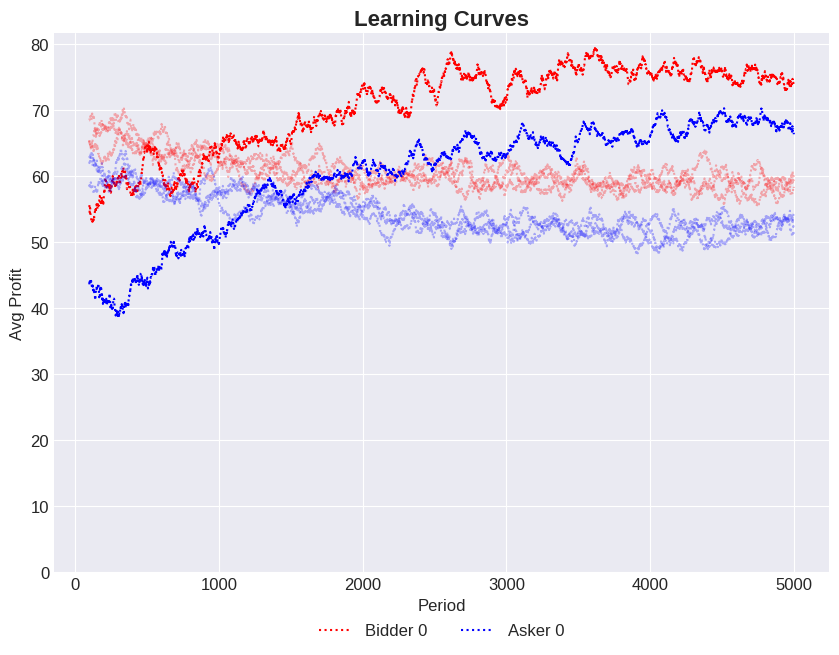

In [17]:
log.findCurrentTraders()
log.graphLearning(rolling_window = 100, trackBuyersIdx=[0], trackSellersIdx=[0], type = 'rnd')

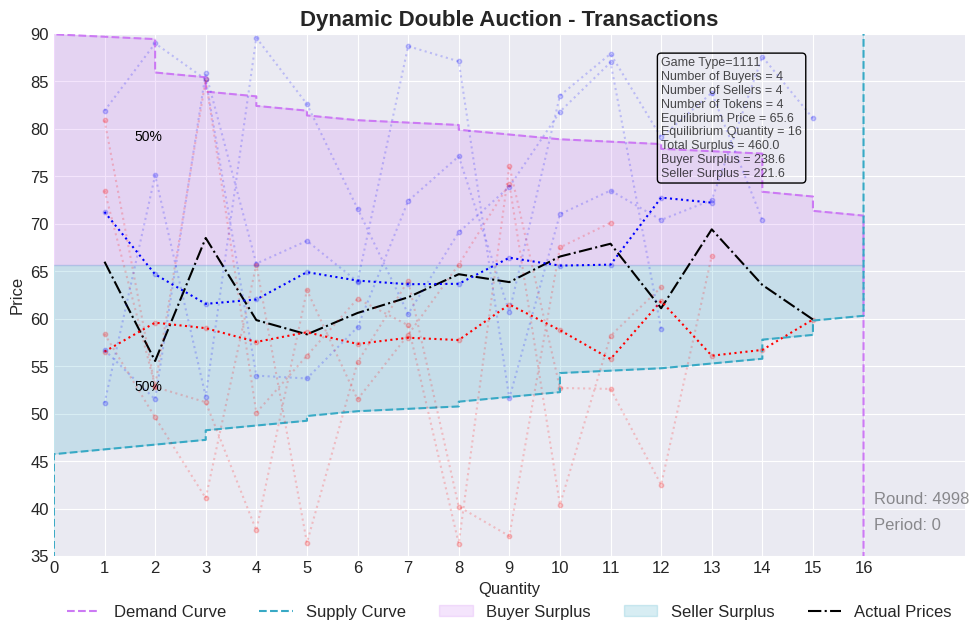

In [18]:
period = 1
log.graphSales(rnd-1, period-1, trackBuyersIdx=[0], trackSellersIdx=[0])

### Last 100 Rounds

In [19]:
df = log.stepData[log.stepData.rnd>(rnd-100)]
df_rnd = log.roundData[log.roundData.rnd>(rnd-100)]

In [20]:
df.columns

Index(['rnd', 'period', 'step', 'currentBid', 'currentAsk', 'buy', 'sell',
       'price', 'sale', 'currentBidIdx_0', 'currentBidIdx_1',
       'currentBidIdx_2', 'currentBidIdx_3', 'currentAskIdx_0',
       'currentAskIdx_1', 'currentAskIdx_2', 'currentAskIdx_3', 'bids_0',
       'bids_1', 'bids_2', 'bids_3', 'asks_0', 'asks_1', 'asks_2', 'asks_3',
       'bprofit', 'sprofit', 'currentBidIdx', 'currentAskIdx', 'tprofit',
       'bids', 'asks'],
      dtype='object')

### Efficiency

In [22]:
x = np.array(df.groupby('rnd').tprofit.sum().values)
y = np.array(df_rnd.totalSurplus)
df_rnd['EFF'] = x/y
df_rnd['EFF'].describe()

count    100.000000
mean       0.986555
std        0.019139
min        0.895025
25%        0.971690
50%        0.999146
75%        1.000055
max        1.001294
Name: EFF, dtype: float64

In [23]:
x = np.array(df.groupby('rnd').bprofit.sum().values)
y = np.array(df_rnd.buyerSurplus)
df_rnd['EFF'] = x/y
df_rnd['EFF'].describe()

count    100.000000
mean       1.032508
std        0.146967
min        0.644176
25%        0.929941
50%        1.031409
75%        1.129918
max        1.389583
Name: EFF, dtype: float64

In [24]:
x = np.array(df.groupby('rnd').sprofit.sum().values)
y = np.array(df_rnd.sellerSurplus)
df_rnd['EFF'] = x/y
df_rnd['EFF'].describe()

count    100.000000
mean       0.973768
std        0.180757
min        0.731799
25%        0.863006
50%        0.921985
75%        1.042901
max        1.920406
Name: EFF, dtype: float64

### Dispersion

In [29]:
x = df[['rnd', 'price']]
x.groupby('rnd').std().mean(), x.groupby('rnd').std().std()

(price    5.113507
 dtype: float64,
 price    0.895765
 dtype: float64)

In [30]:
x = df[['rnd', 'price']]
y = df_rnd[['rnd', 'peq']]
z = pd.merge(x, y, on='rnd')
z['dev'] = z['price'].sub(z['peq']).abs()
z.groupby('rnd').mean().mean()

price    64.242699
peq      64.751000
dev       4.518889
dtype: float64

In [31]:
z.groupby('rnd').mean().std()

price    1.353270
peq      2.200206
dev      0.916213
dtype: float64

In [32]:
autocorr_by_round = df.groupby('rnd')['price'].apply(lambda x: x.autocorr(lag=1))
x = pd.merge(df, autocorr_by_round.reset_index(name='autocorr'), on='rnd')
x.autocorr.mean(), x.autocorr.std()

(-0.027814315161988745, 0.2560687780171035)

### Switching

In [33]:
buyer_switch_mask = df['currentBidIdx'].ne(df['currentBidIdx'].shift())
seller_switch_mask = df['currentAskIdx'].ne(df['currentAskIdx'].shift())
buyer_switch_count = df.groupby('rnd')['period'].apply(lambda x: (buyer_switch_mask & (x == x.shift())).sum())
seller_switch_count = df.groupby('rnd')['period'].apply(lambda x: (seller_switch_mask & (x == x.shift())).sum())

print("Number of buyer switches within each round:")
print(np.mean(buyer_switch_count)/16)

print("\nNumber of seller switches within each round:")
print(np.mean(seller_switch_count)/16)

Number of buyer switches within each round:
0.675

Number of seller switches within each round:
0.70375
